# ARIMA Time Series Analysis of Bitcoin Stok Prices

## 1. Introduction 

This notebook performs a time series analysis on the historical price data of Bitcoin (BTC-USD). The dataset contains daily information on the opening price, highest price, lowest price, closing price, and trading volume. Such data is well-suited for financial modeling tasks, including forecasting future prices and studying market volatility.

In this notebook, we will:

Explore and visualize the data to understand underlying trends and seasonality.

Perform stationarity tests and transformations to prepare the data for modeling.

Build an ARIMA (AutoRegressive Integrated Moving Average) model to forecast future Bitcoin prices.

Evaluate the model performance and visualize predictions.

This analysis aims to demonstrate how ARIMA can be applied to cryptocurrency time series data, providing insights into potential future price movements based on historical patterns.

## 2. Data Exploration 

Let's take a look inside the data

In [1]:
import pandas as pd

data = pd.read_csv('BTC-USD_stock_data.csv')

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008
1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992
2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000
3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984
4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008


So we have:

The date in YYYY-MM-DD format (Date)
Opening Price for the day (Open)
High Price for the day (High)
Low Price for the day (Low)
Closing Price for the day (Close)
Adjusting Closing Price for the day (Adj Close)
Total # of Bitcoin Traded in the day (Volume)

We are now going to reset the index with the date as a datetime object

In [2]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)
data.set_index('Date', inplace=True)

Let's look at the closing price and volume over time with the date adjusted.  We are going to mark surge events in the graph with a function that will label them with numbers.  The events will then be explained in the following box.

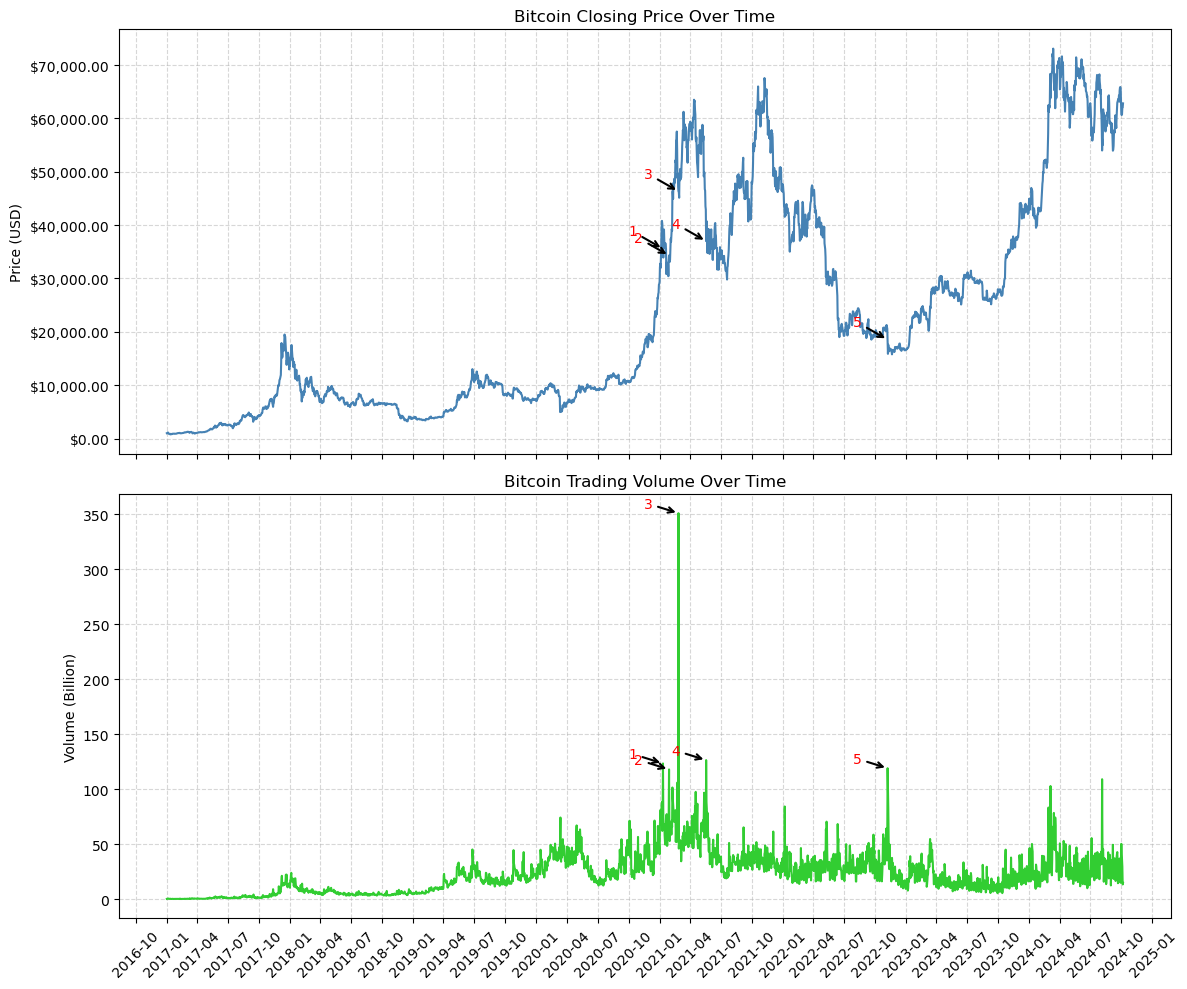

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import numpy as np

def annotate_volume_spikes(ax1, ax2, df, n):

    # rank top
    top_dates = df['Volume'].nlargest(n).index
    top_dates_sorted = sorted(top_dates)

    # annotate both graphs
    for i, date in enumerate(top_dates_sorted, start=1):
        price = df.loc[date, 'Close']
        volume_billion = df.loc[date, 'Volume'] / 1e9

        # annotate top graph (closing price)
        ax1.annotate(f'{i}',
                     xy=(date, price),
                     xytext=(date - pd.Timedelta(days=90), price + 2500),
                     ha='center',
                     color='red',
                     fontsize=10,
                     arrowprops=dict(facecolor='red', arrowstyle='->', lw=1.5))

        # annotate bottom graph (volume)
        ax2.annotate(f'{i}',
                     xy=(date, volume_billion),
                     xytext=(date - pd.Timedelta(days=90), volume_billion + 5),
                     ha='center',
                     color='red',
                     fontsize=10,
                     arrowprops=dict(facecolor='red', arrowstyle='->', lw=1.5))
    
    return top_dates_sorted
        
# plotting function
def plot_price_and_volume(df):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,10), sharex=True)

    # closing subplot
    ax1.plot(df.index, df['Close'], label='Close Price', color='steelblue')
    ax1.set_title('Bitcoin Closing Price Over Time')
    ax1.set_ylabel('Price (USD)')
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x:,.2f}'))
    ax1.grid(True, which='major', linestyle='--', alpha=0.5)

    # volume subplot
    ax2.plot(df.index, df['Volume'] / 1e9, label='Volume (Billions)', color='limegreen')
    ax2.set_title('Bitcoin Trading Volume Over Time')
    ax2.set_ylabel('Volume (Billion)')
    ax2.grid(True, which='major', linestyle='--', alpha=0.5)
    
    # x-axis format
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    
    # annotate top volume spikes
    top_dates = annotate_volume_spikes(ax1, ax2, df, 5)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_price_and_volume(data)

We see some spikes in the volume data, which we can attribute to:

1. **Dec 2020 - Jan 2021**  
   Bitcoin breaks its previous all-time high from 2017 (~$20,000) and surges past $40,000.  
   Massive institutional buying from companies like MicroStrategy and PayPal crypto rollout fuels trading frenzy.

2. **May 2021**  
   China cracks down on Bitcoin mining, forcing a mass miner exodus.  
   Bitcoin falls from ~$60,000 to ~$30,000, causing panic selling and huge trading volumes.

3. **Jul 2021**  
   Continued aftershock from China's mining ban. Network hash rate hits lows, uncertainty remains high, triggering heavy repositioning.

4. **Aug 2022**  
   Crypto lenders Celsius & Voyager file for bankruptcy.  
   Widespread liquidations, DeFi unwinds, and concerns over systemic contagion drive intense trading activity.

5. **Mar 2023**  
   US banking crisis (Silicon Valley Bank, Signature Bank) raises fears over traditional financial systems.  
   Bitcoin sees a short-lived surge in volume as investors look to crypto as a hedge.

Next is a bargraph of the data, showing how much bitcoin was bought per year.

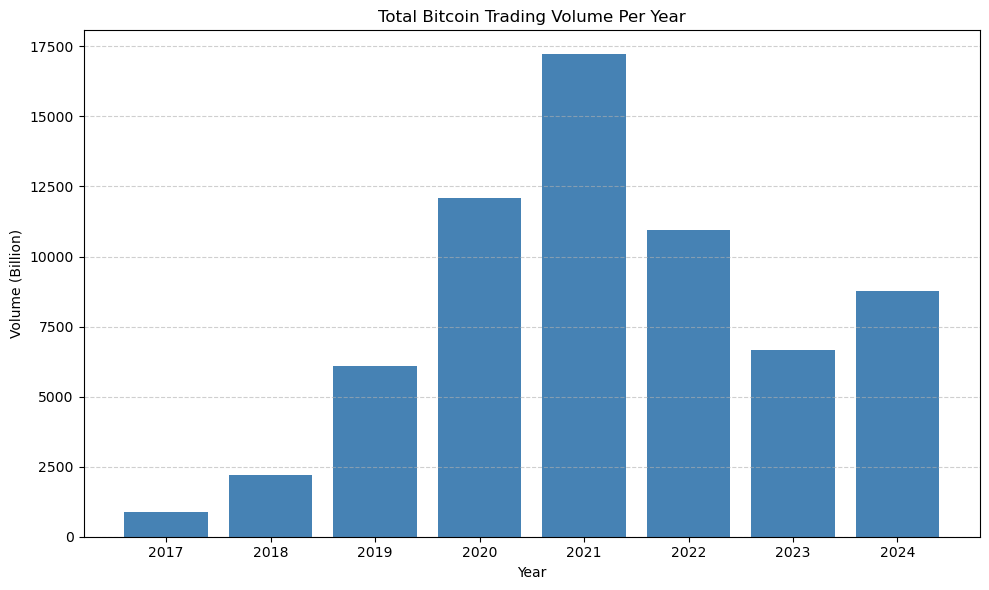

In [4]:
def bargraph(df):

    # group by year
    volume_per_year = df['Volume'].resample('Y').sum()

    # convery index into year
    volume_per_year.index = volume_per_year.index.year
    volume_per_year_billion = volume_per_year / 1e9       # put in billions

    # Plot bar graph
    plt.figure(figsize=(10,6))
    plt.bar(volume_per_year_billion.index, volume_per_year_billion.values, color='steelblue')
    plt.title('Total Bitcoin Trading Volume Per Year')
    plt.xlabel('Year')
    plt.ylabel('Volume (Billion)')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.xticks(volume_per_year_billion.index)
    plt.tight_layout()
    plt.show()
    
bargraph(data)

This bar graph shows the total annual Bitcoin trading volume (in billions) from 2017 through 2024.  We see a steady rise in volume peaking in 2021, driven by institutional adoption and all-time-high price surges, followed by a decline during 2022–2023 due to tightening macroeconomic conditions and crypto-specific setbacks.  Volume begins to rebound slightly in 2024, suggesting renewed market participation.

Next is a moving average graph to smooth out volativity and focus on long term trends.

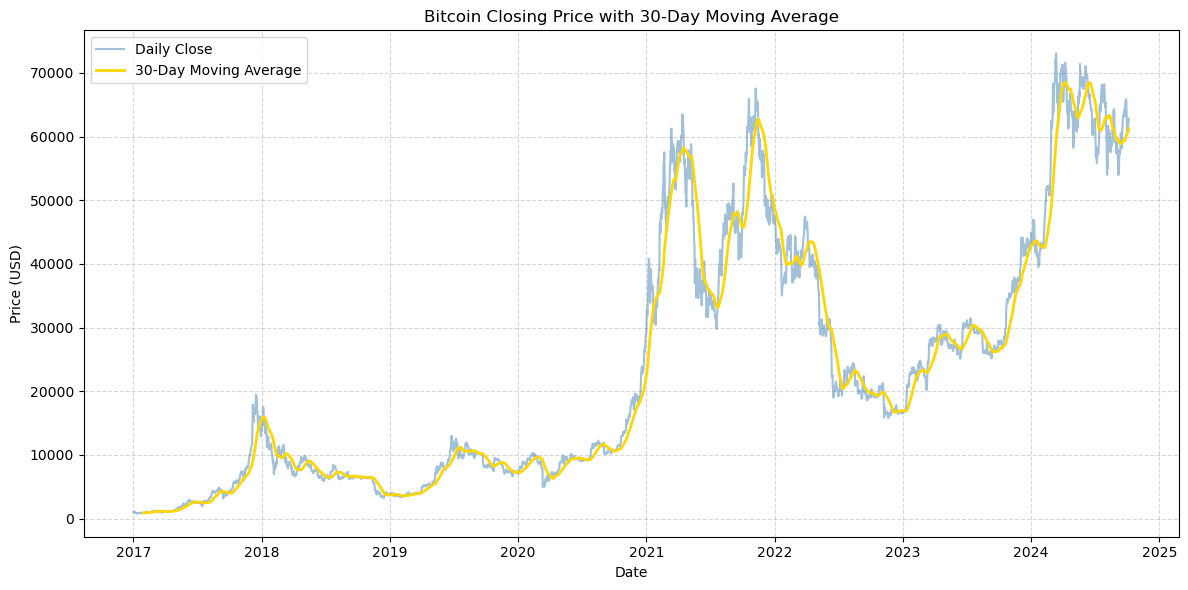

In [5]:
def moving_average_plot(df, window=30):

    # set up moving average
    ma_col = f'MA_{window}'
    df[ma_col] = df['Close'].rolling(window).mean()

    plt.figure(figsize = (12,6))
    plt.plot(df['Close'], alpha = 0.5, label = 'Daily Close', color = 'steelblue')
    plt.plot(df[ma_col], label = f'{window}-Day Moving Average', linewidth = 2, color = 'gold')
    plt.title(f'Bitcoin Closing Price with {window}-Day Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
moving_average_plot(data)

This line graph shows the daily closing price of Bitcoin (light blue) overlaid with a 30-day moving average (gold).  The moving average smooths out short-term fluctuations to highlight longer-term price trends and cycles.  We can clearly see major bull runs in late 2017, late 2020 through early 2021, and again in 2024, as well as significant corrections in 2018, 2022, and parts of 2023.

We will now look at the daily returns measure the percentage change in the closing price from one day to the next.  This is calculated with the following

$$
\text{Return}_t = \frac{\text{Close}_t - \text{Close}_{t-1}}{\text{Close}_{t-1}}
$$

In pandas we can use **.pct_change()** for our data.  With the return values calculated we can fit a probability density function over our distribution by calculaing the mean and standard deviation of the returns.  We can also calculate the skewness and kurtosis of the distribution, which can tell us the following:

- **Skewness** measures asymmetry of the distribution. A skew > 0 means the right tail is longer (more large positive returns), while skew < 0 means the left tail is longer (more large losses).

- **Kurtosis** measures "tailedness" or how heavy/extreme the tails are compared to a normal distribution (which has kurtosis = 3).  Higher kurtosis (>3) suggests more frequent extreme events — typical for volatile assets like Bitcoin.

By comparing Bitcoin's daily return histogram to a normal curve, and looking at skew & kurtosis, we can see how Bitcoin deviates from typical financial models that assume normal returns.

Mean:     0.00218
Std Dev:  0.03776
Skewness: -0.05
Kurtosis: 7.21


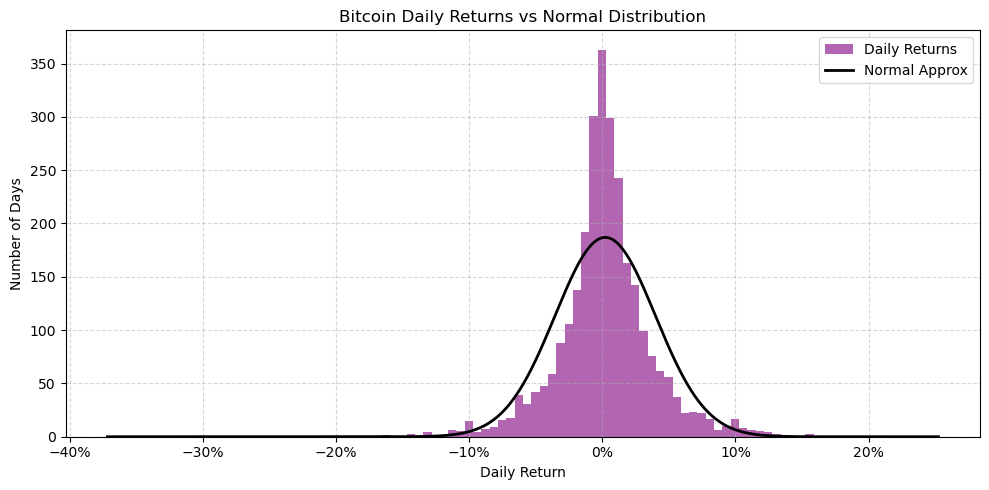

In [6]:
import scipy.stats as stats

def plot_returns_with_normal(df):

    # percent changes
    returns = df['Close'].pct_change().dropna()
    mean = returns.mean()
    std = returns.std()

    # skewness and kurtosis
    skewness = returns.skew()
    kurt = returns.kurtosis()

    print(f"Mean:     {mean:.5f}")
    print(f"Std Dev:  {std:.5f}")
    print(f"Skewness: {skewness:.2f}")
    print(f"Kurtosis: {kurt:.2f}")

    # histogram
    plt.figure(figsize=(10,5))
    count, bins, ignored = plt.hist(returns, bins = 100, density = False, 
                                    color = 'purple', alpha = 0.6, label = 'Daily Returns')

    # normal distribution overlay
    x = np.linspace(returns.min(), returns.max(), 1000)
    #plt.plot(x, stats.norm.pdf(x, mean, std), 'k', linewidth = 2, label = 'Normal PDF')
    pdf = stats.norm.pdf(x, mean, std)
    plt.plot(x, pdf * len(returns) * (bins[1] - bins[0]), 'k', linewidth = 2, label = 'Normal Approx')
    
    # x-axis format
    plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1.0))

    plt.title('Bitcoin Daily Returns vs Normal Distribution')
    plt.xlabel('Daily Return')
    plt.ylabel('Number of Days')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_returns_with_normal(data)

This plot compares the histogram of Bitcoin's daily percentage returns (purple bars) to a normal distribution (black line) with the same mean and standard deviation.  The slight negative skewness (-0.05) indicates that extreme losses are marginally more frequent than extreme gains.  The high kurtosis value (7.21), well above the normal benchmark of 3, reflects "fat tails" — a greater likelihood of large, unexpected price swings.  This emphasizes the heavy-tailed nature of Bitcoin's returns, highlighting that extreme events occur more often than would be predicted by a standard normal model.

In the next section we are going to conduct time-series modeling with our bitcoin stock prices with ARIMA

## 3. Using ARIMA for time-series modeling 

ARIMA stands for **AutoRegressive Integrated Moving Average**, a class of statistical models for analyzing and forecasting time series data.  It combines three key components:

- **AR (AutoRegressive)**: The model uses a linear combination of past values to predict the current value.  
  For example, today's Bitcoin price may be partly influenced by the prices of previous days.

- **I (Integrated)**: Differencing is applied to the data to make it stationary, meaning the statistical properties (like mean and variance) remain constant over time.

- **MA (Moving Average)**: The model incorporates the dependency between an observation and residual errors from a moving average model applied to lagged forecast errors.

The model is typically referred to by its parameters as **ARIMA(p,d,q)** where:
- **p** is the order (number of lags) of the autoregressive component,
- **d** is the degree of differencing required to make the series stationary,
- **q** is the order of the moving average component.

We want to use ARIMA to do time-series modeling on bitcoin price data bevause it is inherently sequential and time-dependent. ARIMA is particularly well-suited for modeling such time series, capturing both the trend and short-term fluctuations in price movements.

Using ARIMA, we aim to understand the underlying temporal structure of Bitcoin prices, forecast future values based on historical trends, and quantify how well our model explains and predicts the observed data.

The first thing we need to do is test the data for stationarity.  Stationarity means that the statistical properties of a time series — like its mean, variance, and autocorrelation — stay constant over time.  Applying ARIMA to non-stationary data leads to biased or misleading forecasts because the model assumes a stable relationship that simply doesn't exist.



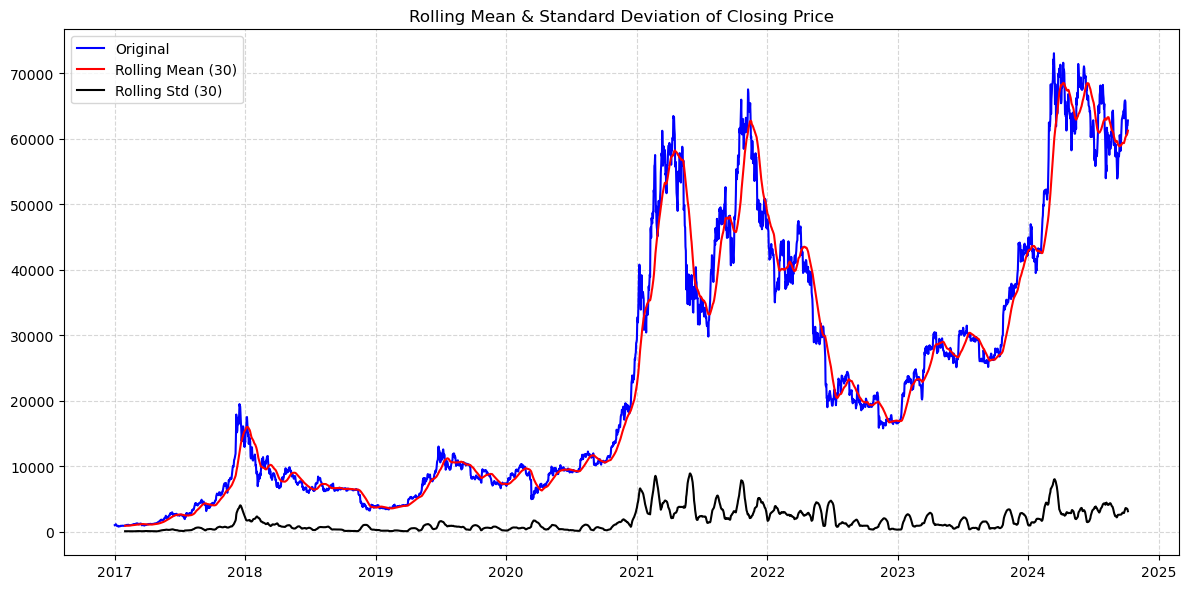


Results of Augmented Dickey-Fuller Test:
ADF Statistic : -1.1026
p-value       : 0.7140
Critical Value 1%: -3.4327
Critical Value 5%: -2.8626
Critical Value 10%: -2.5673

⚠️ The series is likely non-stationary (fail to reject null hypothesis at 5%).


In [7]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(df, window):

    series = df['Close'].dropna()

    # Plot rolling statistics
    rolmean = series.rolling(window=window).mean()
    rolstd = series.rolling(window=window).std()

    plt.figure(figsize=(12,6))
    plt.plot(series, color='blue', label='Original')
    plt.plot(rolmean, color='red', label=f'Rolling Mean ({window})')
    plt.plot(rolstd, color='black', label=f'Rolling Std ({window})')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation of Closing Price')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Perform Dickey-Fuller test
    print('\nResults of Augmented Dickey-Fuller Test:')
    adf_result = adfuller(series)
    print(f'ADF Statistic : {adf_result[0]:.4f}')
    print(f'p-value       : {adf_result[1]:.4f}')
    for key, value in adf_result[4].items():
        print(f'Critical Value {key}: {value:.4f}')

    if adf_result[1] < 0.05:
        print("\n✅ The series is likely stationary (reject null hypothesis at 5% level).")
    else:
        print("\n⚠️ The series is likely non-stationary (fail to reject null hypothesis at 5%).")
        
        
check_stationarity(data, 30)


Time series models like ARIMA assume that the underlying data is stationary — meaning its statistical properties such as mean, variance, and autocorrelation structure do not change over time. 

However, financial time series like Bitcoin prices typically exhibit trends, cycles, and varying volatility, violating this assumption. Using non-stationary data in ARIMA would lead to unreliable parameter estimates and forecasts, because the relationships the model learns would not be consistent over time.

To address this, we difference the data — subtracting each value from its previous value — to stabilize the mean and remove trends. We then use statistical tests (like the Augmented Dickey-Fuller test) to confirm that the transformed series is stationary.  Given that we are dealing with something that we expect to not have stationarity, we will apply **np.log** to smooth it out for assistance.

ADF Test after 0 differencing(s): p-value = 0.2589
ADF Test after 1 differencing(s): p-value = 0.2589
ADF Test after 2 differencing(s): p-value = 0.2589
ADF Test after 3 differencing(s): p-value = 0.2589
ADF Test after 4 differencing(s): p-value = 0.2589
⚠️ Reached max differencing (5) and still not stationary (p = 0.2589). Proceed with caution.


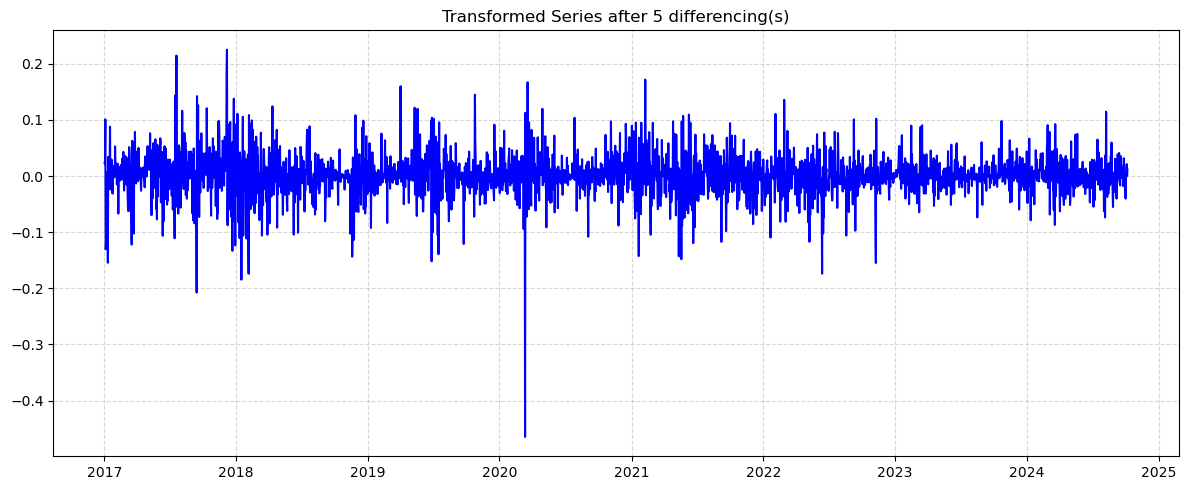

In [8]:
def prepare_stationary_series(df, max_):

    diff_count = 0
    log_series = np.log(df["Close"].dropna())
    
    while diff_count < max_:
        adf_result = adfuller(log_series)
        p_value = adf_result[1]
        print(f"ADF Test after {diff_count} differencing(s): p-value = {p_value:.4f}")
        if p_value < 0.05:
            print(f"Stationarity achieved after {diff_count} differencing(s).")
            break
        else:
            # Difference again
            closing = log_series.diff()
            diff_count += 1

    if diff_count == max_ and p_value >= 0.05:
        print(f"⚠️ Reached max differencing ({5}) and still not stationary (p = {p_value:.4f}). Proceed with caution.")

    # final DataFrame for ARIMA
    prepared_df = pd.DataFrame({f'{"Close"}_diff_{diff_count}': closing})
    
    # plot
    plt.figure(figsize=(12,5))
    plt.plot(closing, color='blue')
    plt.title(f'Transformed Series after {diff_count} differencing(s)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return prepared_df

arima_data = prepare_stationary_series(data, 5)

With our data now log-transformed and differenced to achieve approximate stationarity, we can build an ARIMA model.  ARIMA combines autoregression (AR), differencing (I), and moving averages (MA) to capture the time series structure.  We'll start by fitting an ARIMA model, then assess its residuals to ensure it is a good fit.  First we will run a function that can find the best order numbers (p,d,q) to use for our data.

In [10]:
from pmdarima import auto_arima

def order_finder(df):
    
    auto_model = auto_arima(df.iloc[:,0], 
                    start_p=0, start_q=0,
                    max_p=5, max_q=5,
                    seasonal=False, trace=True,
                    error_action='ignore', suppress_warnings=True,
                    stepwise=True)

    print(auto_model.summary())
    
order_finder(arima_data.dropna())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-10492.479, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-10492.582, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-10492.418, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-10494.847, Time=0.38 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-10492.974, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-10493.082, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-10492.490, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-10490.980, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-10496.957, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-10495.012, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-10495.036, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-10495.090, Time=0.53 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-10494.935, Time=0.42 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-10493.042, Time=1.19 sec

Best

Our best model is going to be (2,0,0).  We shall now move forward to ARIMA fitting with this order.

In [11]:
from statsmodels.tsa.arima.model import ARIMA

def ARIMA_fit(df, order):

    # We'll use order (1,0,1) for demonstration, as is common for financial series
    model = ARIMA(df.iloc[:,0], order=order)
    model_fit = model.fit()

    # Summary of the model
    print(model_fit.summary())
    
    return model_fit

MODEL = ARIMA_fit(arima_data, (2,0,0))

/Users/eb64/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/eb64/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/eb64/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           Close_diff_5   No. Observations:                 2836
Model:                 ARIMA(2, 0, 0)   Log Likelihood                5252.478
Date:                Tue, 08 Jul 2025   AIC                         -10496.957
Time:                        19:30:54   BIC                         -10473.156
Sample:                    01-01-2017   HQIC                        -10488.371
                         - 10-06-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.985      0.047    1.83e-05       0.003
ar.L1         -0.0278      0.013     -2.171      0.030      -0.053      -0.003
ar.L2          0.0373      0.016      2.391      0.0

The ARIMA(1,0,1) model on our log-differenced series reveals a slight positive drift (const ≈ 0.0015), though neither the AR nor MA components are individually significant at typical 5% levels.  The Ljung-Box test p-value of 0.67 indicates we fail to reject the null hypothesis of no autocorrelation in residuals, suggesting a good fit in terms of temporal dependencies.  However, the Jarque-Bera test p-value < 0.001 and high kurtosis (~14) show the residuals are far from normally distributed, exhibiting heavy tails typical in cryptocurrency markets.  The heteroskedasticity test (H = 0.39, p < 0.001) suggests changing volatility over time, also common in Bitcoin data.

In summary, while the ARIMA model captures the autocorrelation structure reasonably well, the residual diagnostics highlight volatility clustering and fat-tailed behavior that ARIMA does not inherently model — motivating future exploration with models like GARCH for volatility.

To validate the ARIMA model, we analyze its residuals.  A well-fit model should have residuals that resemble white noise: no autocorrelation, normally distributed, and roughly zero mean. 

We'll check this using:
- Residual time series plots
- Autocorrelation plots (ACF & PACF)
- Q-Q plots to check normality
- The Ljung-Box test to statistically test for remaining autocorrelation.

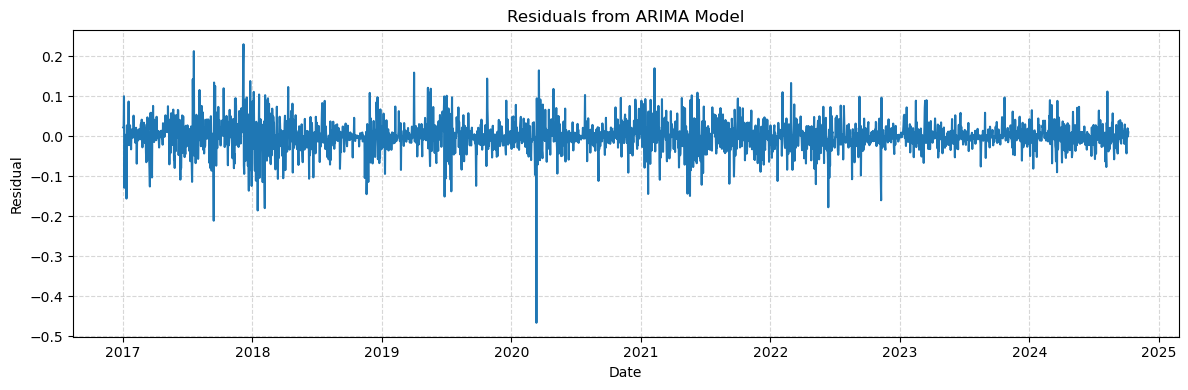

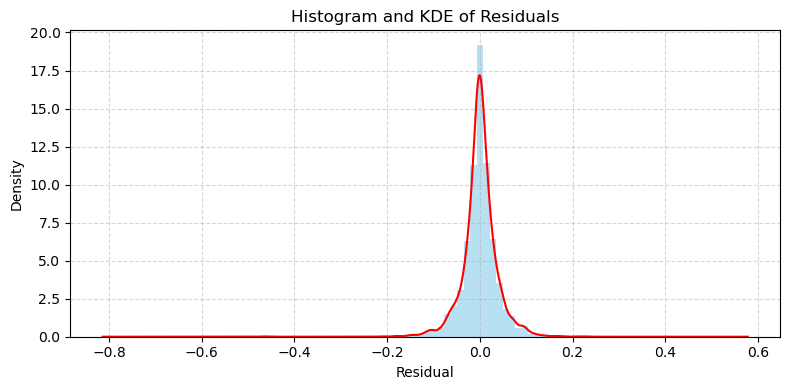

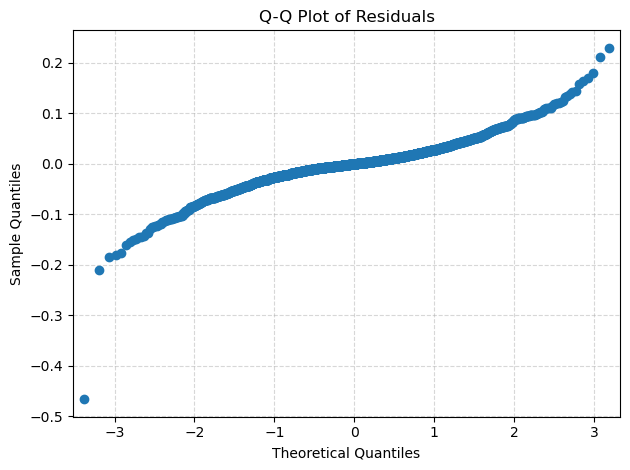

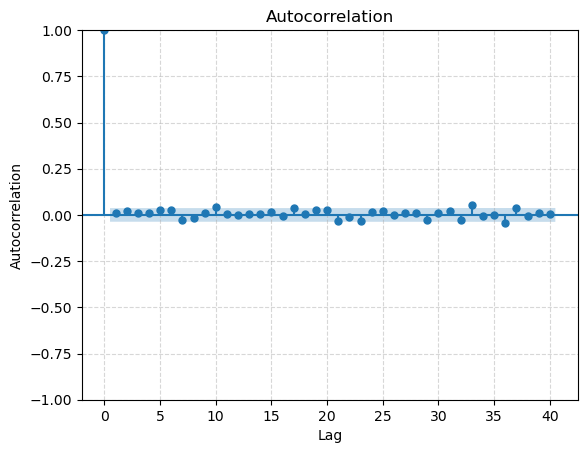

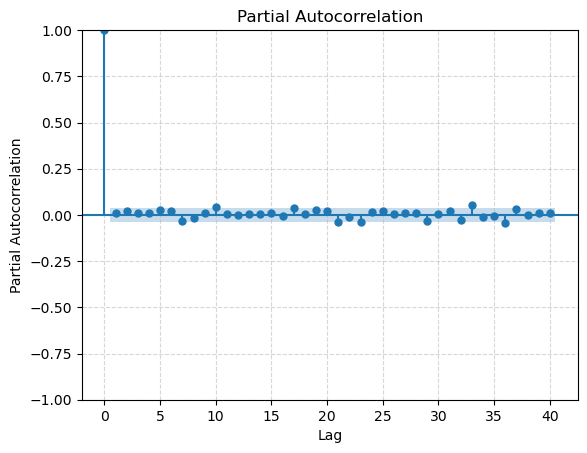

In [41]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def stats_arima(df, model_fit):

    residuals = model_fit.resid

    # Residual time plot
    plt.figure(figsize=(12,4))
    plt.plot(residuals)
    plt.title('Residuals from ARIMA Model')
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Histogram and KDE
    residuals.plot(kind='hist', bins=50, density=True, alpha=0.6, figsize=(8,4), color='skyblue')
    residuals.plot(kind='kde', color='red')
    plt.title('Histogram and KDE of Residuals')
    plt.xlabel('Residual')
    plt.ylabel('Density')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Q-Q plot
    sm.qqplot(residuals, line='s')
    plt.title('Q-Q Plot of Residuals')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # ACF and PACF plots
    plot_acf(residuals.dropna(), lags=40)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    plot_pacf(residuals.dropna(), lags=40)
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    
stats_arima(arima_data, MODEL)

Quick Points on the graphs

- The residuals fluctuate around zero with no apparent trend, which supports the adequacy of the ARIMA model in capturing the mean structure.
- The histogram and KDE plot show a strong peak and heavy tails, consistent with our earlier findings of high kurtosis.
- The Q-Q plot highlights deviations from normality in the tails, which is common in financial time series due to extreme events.
- The ACF and PACF plots show no significant autocorrelations, reinforcing that the residuals approximate white noise.
- Overall, while the ARIMA model adequately models the temporal dependencies, the heavy tails and volatility clustering hint at areas for future exploration, such as fitting a GARCH model for conditional volatility.



1. **Test for stationarity** using rolling statistics and the Augmented Dickey-Fuller (ADF) test.
2. **Transform the data** (if needed) by differencing to achieve stationarity.
3. **Use ACF and PACF plots** to identify optimal ARIMA parameters.
4. **Fit an ARIMA model** to the Bitcoin closing price data.
5. **Forecast future prices**, and visualize the predictions against historical data.
6. **Examine residuals** to assess the quality of the fit and ensure the model assumptions hold.

By following this process, we build a robust foundation for forecasting Bitcoin prices using classical time series techniques.